In [563]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import nex 
import networkx as nx
import networkx.algorithms.community as nx_comm
import leidenalg as la
import igraph as ig
import numpy as np

In [564]:
# Load data
data = pd.read_csv("d151-m71labels_pose_100HzD151_m71_100722_20Hz_30pulse_bilat_atNoseBB_0msDelay_corrected.csv")

In [565]:
# behavior class that stores start & end frames, cluster ID, & length of behavior
class Behavior:
    def __init__(self, start, end, id, next):
        self.start = start
        self.end = end
        self.length = end - start + 1
        self.id = id
        self.next = next

In [566]:
# behaviors and group by behavior in dictionary
behaviors = {}

previous_id = data.iloc[0, 0]
start = 0

# pass through all frames
for x in range( len(data)-1 ):
    x = x + 1
    frame = data.iloc[x, 0]
    id = data.iloc[x, 1]
    
    # if change in label
    if id != previous_id:
        behavior = Behavior(start, x-1, previous_id, id)


        # add to dictionary by ID
        if previous_id not in behaviors.keys():  
            behaviors[previous_id] = []
        behaviors[previous_id].append(behavior)
        
        # start new behavior
        start = x
        previous_id = id

In [567]:
# grouped behaviors by id and extract total num frames and all next transitions
transitions = {}
nodes = {}

for id, behavs in behaviors.items():
    nexts = []
    total_frames = 0
    
    for b in behavs:
        total_frames += b.length
        nexts.append(b.next)
        
    transitions[id] = nexts       # k: id, v: total list of next ids
    nodes[id] = total_frames      # k: id, v: total num frames

In [568]:
# function to make edges from a dictionary of transitions

def make_edges(transitions):
    edges = []

    for c, nexts in transitions.items():
        nexts_set = set(nexts)

        for n in nexts_set:
            transition_prob = nexts.count(n) / len(nexts)   # get transition probability
            edges.append( (c, n, transition_prob) )         # edge: from, to, weight
            
    # filter out small edges
    THRESHOLD = 0.1
    edges = [e for e in edges if e[2] > THRESHOLD]
    
    return edges


In [569]:
# get transition probabilities and make edges
edges = make_edges(transitions)

In [570]:
# function to draw a graph with weighted nodes and edges

def draw_graph(nodes, edges):
    # initialize graph with edges
    transition_graph = nx.DiGraph()
    transition_graph.add_weighted_edges_from(edges)
    
    # draw graph with scaled nodes and edges
    widths = nx.get_edge_attributes(transition_graph, 'weight')

    # scale edges and nodes
    for id, w in widths.items():
        widths[id] = w * 10

    node_sizes = {}
    for id, s in nodes.items():
        node_sizes[id] = s * 2
        
    # labels
    node_labels = dict(zip(node_sizes.keys(), node_sizes.keys()))
    edge_labels = dict(zip( [(e[0], e[1]) for e in edges], [round(e[2],3) for e in edges] ))

    # setup figure
    plt.figure(figsize=(12,8))

    # setup graph
    pos = nx.circular_layout(transition_graph)

    # draw graph
    nx.draw_networkx_nodes(transition_graph, pos,
                        nodelist = list(node_sizes.keys()),
                        node_size = list(node_sizes.values()),
                        node_color = 'black',
                        alpha = 0.7)

    nx.draw_networkx_edges(transition_graph, pos,
                        edgelist = widths.keys(),
                        width = list(widths.values()),
                        edge_color = 'lightblue',
                        alpha=0.6)

    # label graph
    nx.draw_networkx_labels(transition_graph, pos,
                            labels = dict(zip(node_sizes.keys(), node_sizes.keys())),
                            font_color='white', font_size=8)

    nx.draw_networkx_edge_labels(transition_graph, pos,
                                edge_labels= edge_labels,
                                font_color='black', font_size=8)

    plt.box(False)
    plt.show()
    
    return transition_graph

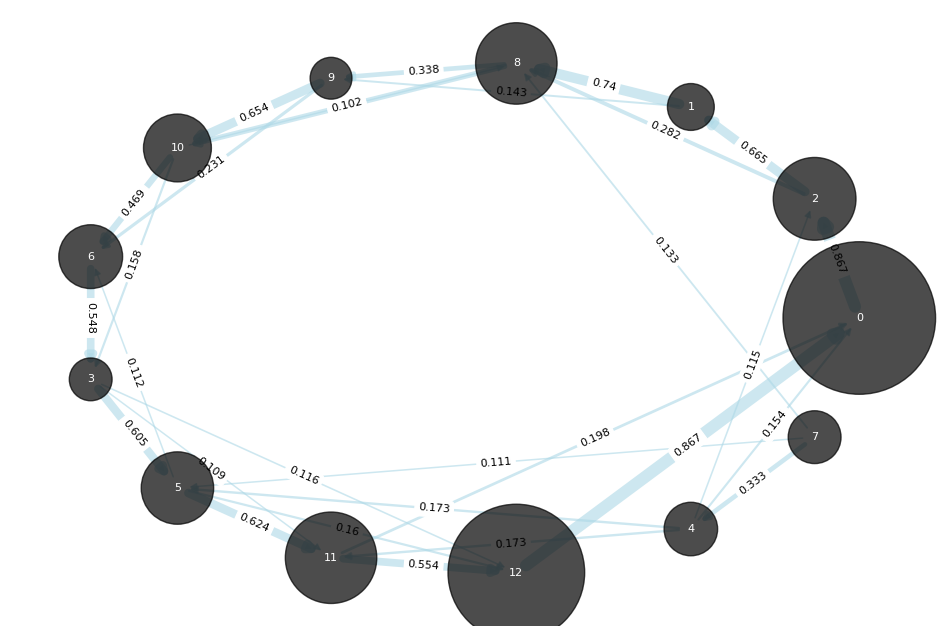

In [571]:
transition_graph = draw_graph(nodes, edges)

In [572]:
# map all old transition nexts to new cluster ids
def map_transitions(transitions, clusters):
    # mapping of olds ids to new ids
    new_map = {}
    for i in range(len(clusters)):
        for c in clusters[i]:
            new_map[c] = i
    
    # converting old next ids to new cluster ids
    mapped_transitions = {}
    for id, nexts in transitions.items():
        mapped_nexts = [new_map[i] for i in nexts]
        mapped_transitions[id] = mapped_nexts      
    
    return mapped_transitions

In [573]:
# Get Louvain clusters
cluster_perms = []
for r in np.arange(0.05, 2, 0.05):
    louvain_clusters = nx_comm.louvain_communities(transition_graph, 
                                                resolution=round(r, 3))
    # print(round(r, 3), ": ", len(louvain_clusters))
    if len(louvain_clusters) == 4:
        louvain_clusters = sorted([list(c) for c in louvain_clusters])
        if louvain_clusters not in cluster_perms:
            cluster_perms.append(louvain_clusters)
            print(louvain_clusters)

[[0, 12], [3, 4, 5, 7, 11], [8, 1, 2], [9, 10, 6]]
[[0, 2, 12], [1, 6, 8, 9, 10], [4, 7], [11, 3, 5]]


In [574]:
def cluster_to_graph(transitions, louvain_clusters):
    # convert transitions based on new clusters
    mapped_transitions = map_transitions(transitions, louvain_clusters)

    # make new edges and nodes
    louvain_nodes = {}
    new_transitions = {}

    node_idx = 0
    for cluster in louvain_clusters:
        
        # make new node counts and transition probs
        total_frames = 0
        
        for c in cluster:
            total_frames += nodes[c]                            # add frames of each c
            
            if node_idx in new_transitions:
                new_transitions[node_idx] = new_transitions[node_idx] + mapped_transitions[c]    # add nexts of each c
            else: 
                new_transitions[node_idx] = mapped_transitions[c]

        louvain_nodes[node_idx] = total_frames                  # make new nodes
        
        node_idx += 1

    louvain_edges = make_edges(new_transitions)   # make new edges

    # plot louvaine graph
    louvain_graph = draw_graph(louvain_nodes, louvain_edges)
    
    return louvain_graph

[[0, 12], [3, 4, 5, 7, 11], [8, 1, 2], [9, 10, 6]]


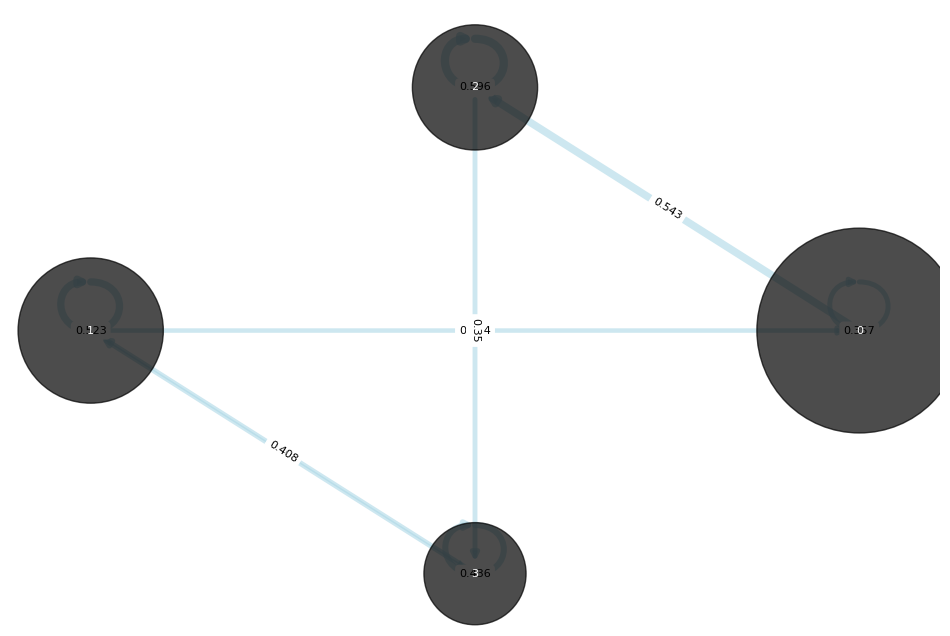

[[0, 2, 12], [1, 6, 8, 9, 10], [4, 7], [11, 3, 5]]


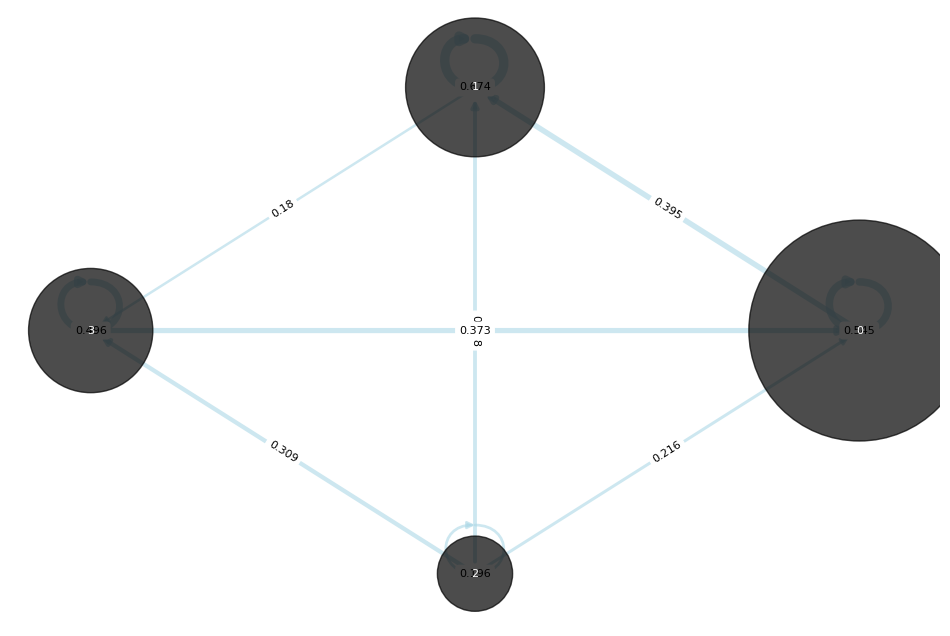

In [575]:
graphs = []
for perm in cluster_perms:
    print(perm)
    graph = cluster_to_graph(transitions, perm)
    graphs.append(graph)

In [576]:
best = []
for i in range(len(graphs)):
    graph = graphs[i]
    H = graph.copy()
    H.remove_edges_from(nx.selfloop_edges(graph))
    cycles = sorted(nx.simple_cycles(H))
    print(cycles)
    if len(cycles) == 1:
        # print(cycles)
        best.append([cluster_perms[i], graph])
    
print("Best permutations: ", best)

[[0, 2, 3, 1], [1, 3]]
[[0, 1, 3]]
Best permutations:  [[[[0, 2, 12], [1, 6, 8, 9, 10], [4, 7], [11, 3, 5]], <networkx.classes.digraph.DiGraph object at 0x16a5ffbe0>]]


In [577]:
# get louvain clusters
louvain_clusters = nx_comm.louvain_communities(transition_graph)

# convert transitions based on new clusters
mapped_transitions = map_transitions(transitions, louvain_clusters)

# make new edges and nodes
louvain_nodes = {}
new_transitions = {}

node_idx = 0
for cluster in louvain_clusters:
    
    # make new node counts and transition probs
    total_frames = 0
    
    for c in cluster:
        total_frames += nodes[c]                            # add frames of each c
        
        if node_idx in new_transitions:
            new_transitions[node_idx] = new_transitions[node_idx] + mapped_transitions[c]    # add nexts of each c
        else: 
            new_transitions[node_idx] = mapped_transitions[c]

    louvain_nodes[node_idx] = total_frames                  # make new nodes
    
    node_idx += 1

louvain_edges = make_edges(new_transitions)   # make new edges

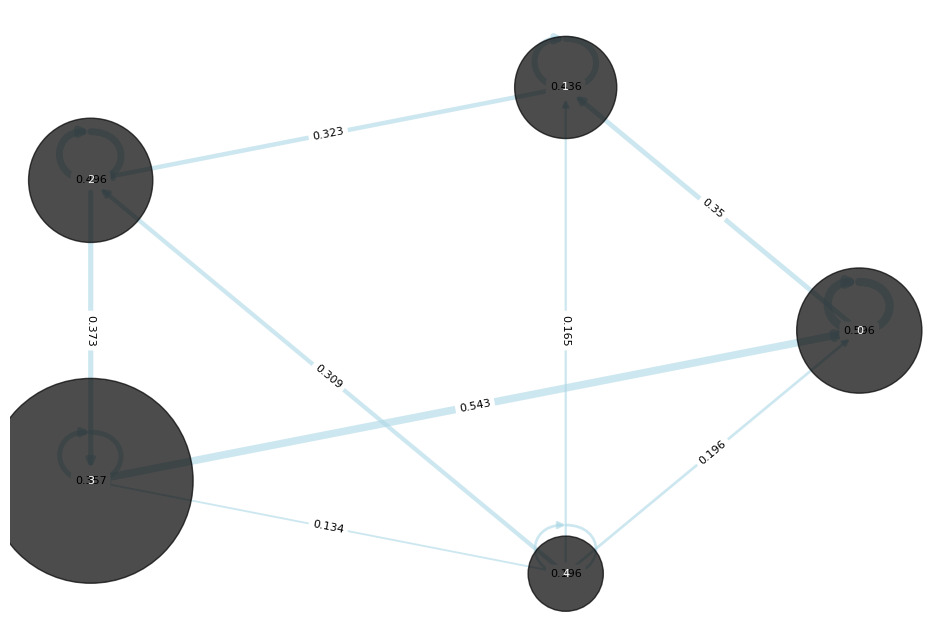

In [578]:
# plot louvaine graph
louvain_graph = draw_graph(louvain_nodes, louvain_edges)

In [579]:
# Get leiden clusters
transition_graph_ig = ig.Graph.TupleList(edges)
leiden_clusters = la.find_partition(transition_graph_ig, 
                                    partition_type=la.CPMVertexPartition,
                                    resolution_parameter=0.3)
print(leiden_clusters)

# convert transitions based on new clusters
mapped_transitions_leiden = map_transitions(transitions, leiden_clusters)

Clustering with 13 elements and 3 clusters
[0] 6, 3, 5, 11, 12
[1] 1, 8, 9, 10
[2] 0, 2, 4, 7


In [580]:
# make new edges and nodes
leiden_nodes = {}
new_transitions = {}

node_idx = 0
for cluster in leiden_clusters:
    
    # make new node counts and transition probs
    total_frames = 0
    
    for c in cluster:
        total_frames += nodes[c]                            # add frames of each c
        
        if node_idx in new_transitions:
            new_transitions[node_idx] = new_transitions[node_idx] + mapped_transitions_leiden[c]    # add nexts of each c
        else: 
            new_transitions[node_idx] = mapped_transitions_leiden[c]

    leiden_nodes[node_idx] = total_frames                  # make new nodes
    
    node_idx += 1

leiden_edges = make_edges(new_transitions)   # make new edges

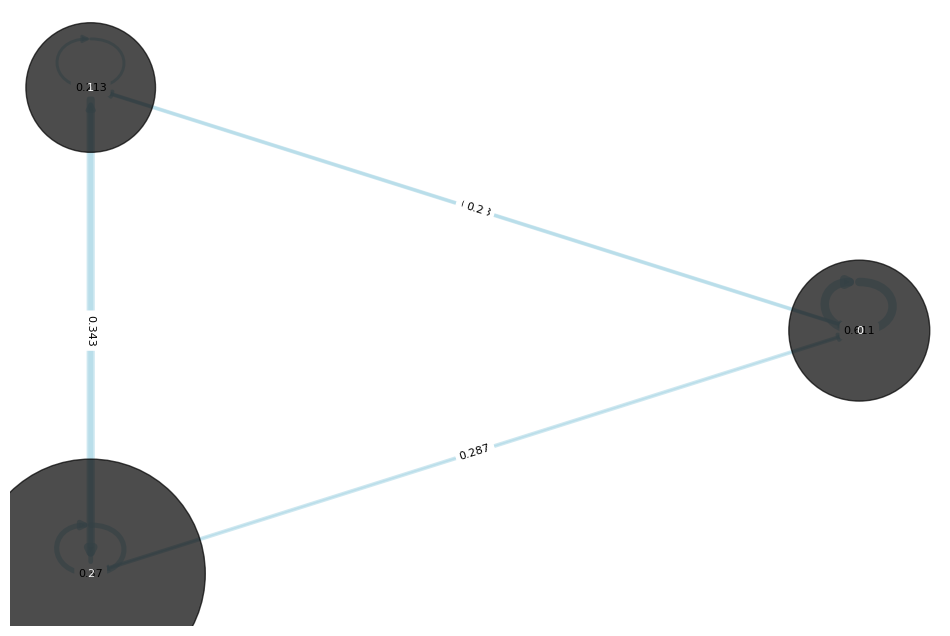

In [581]:
# plot leiden graph
leiden_graph = draw_graph(leiden_nodes, leiden_edges)